# Load video
Before we start this, we have to upload the videos to the folder `videos/`

# Pre-requisite installation
We have to install the necessary libraries, which includes:
* einops for performing complex tensor operations,
* opencv for video files processing
* tensorflow

In [ ]:
!pip install einops opencv-python tensorflow==2.10.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 41.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling te

# Import required libraries

In [ ]:
import cv2
import einops
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf

import keras
from keras import layers

# Define global constants

In [ ]:
TARGET_SIZE = (224, 224)
HEIGHT = 224
WIDTH = 224

# Videos processing

Here we define the utility functions which are used for processing the videos files, that includes:


1. `frames_from_video_file` splits the videos into frames, reads the `need_frames` amount of frames, during the selected time window (from `start_time_ms` to `end_time_ms`) out of a video file, and returns them as a NumPy array.  
2. `format_frames` which convert image datatype to `tf.float32` which allows more accurate computations and followed by resize to `224x224` with padding if necessary

In [ ]:
def format_frames(frame, output_size):
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame


def frames_from_video_file(video_path, start_time_ms, end_time_ms, need_frames = 90, output_size = TARGET_SIZE):
    result = []

    src = cv2.VideoCapture(str(video_path))
    src.set(cv2.CAP_PROP_POS_MSEC, start_time_ms)

    while(src.isOpened() and need_frames > 0):
        ret, frame = src.read()
        if ret:
            need_frames -= 1
            result.append(format_frames(frame, output_size))
        elif src.get(cv2.CAP_PROP_POS_MSEC) <= end_time_ms:
            result.append(np.zeros_like(result[0]))
        else:
            break

    src.release()
    result = np.array(result)[..., [2, 1, 0]]
    return result

FrameGenerator class is a generator that yields batches of video frames along with corresponding class numerical labels ("non-flapping": 0, "flapping": 1)

In [ ]:
class FrameGenerator:
    def __init__(self, videos_and_segments, n_frames=90):
        self.videos_and_segments = videos_and_segments
        self.n_frames = n_frames
        self.class_label_mapping = {"non-flapping": 0, "flapping": 1}


    def __call__(self):
        for video_path, segments in self.videos_and_segments:
            for start_time_ms, end_time_ms, class_name in segments:
                video_frames = frames_from_video_file(video_path, start_time_ms, end_time_ms, self.n_frames)
                yield video_frames, self.class_label_mapping[class_name]


`videos_and_segments` consists the manually extracted information from the data preparation stage where we identified the instances of self-stimulating behaviors displayed by the children in each videos and the corresponding timecodes. It is then converted to an array which is structured as follows: `video_path`, `[start time, end time, label]` that represents the video path, start time, end time, and the corresponding label.

In [ ]:
videos_and_segments = [
    ("videos/1.mp4", [(35000, 41000, 'flapping'), (65000, 67000, 'flapping'), (97000, 101000, 'flapping'), (110000, 114000, 'flapping'), (135000, 138000, 'flapping')]),
    ("videos/3.mp4", [(0, 4000, 'flapping'), (33000, 48000, 'flapping'), (66000, 83000, 'flapping'), (19000, 27000, 'non-flapping')]),
    ("videos/4.mp4", [(5000, 9000, 'flapping')]),
    ("videos/5.mp4", [(4000, 8000, 'flapping'), (9000, 11000, 'flapping')]),
    ("videos/6.mp4", [(1000, 2000, 'flapping'), (5000, 8000, 'flapping'), (49000, 51000, 'flapping'), (12000, 14000, 'flapping'), (19000, 22000, 'flapping'), (26000, 27000, 'flapping'), (61000, 63000, 'flapping'), (70000, 71000, 'flapping')]),
    ("videos/7.mp4", [(5000, 8000, 'flapping'), (15000, 18000, 'flapping')]),
    ("videos/8.mp4", [(2000, 5000, 'flapping'), (8000, 11000, 'flapping'), (14000, 17000, 'flapping')]),
    ("videos/9.mp4", [(1000, 6000, 'flapping'), (19000, 26000, 'flapping')]),
    ("videos/10.mp4", [(1000, 2000, 'flapping'), (4000, 5000, 'flapping'), (15000, 18000, 'flapping'), (21000, 22000, 'flapping'), (24000, 26000, 'flapping'), (30000, 31000, 'flapping'), (39000, 43000, 'flapping'), (69000, 74000, 'flapping'), (89000, 91000, 'flapping'), (99000, 100000, 'flapping')]),
    ("videos/11.mp4", [(0, 1000, 'flapping')]),
    ("videos/12.mp4", [(14000, 18000, 'flapping'), (34000, 38000, 'flapping')]),
    ("videos/13.mp4", [(7000, 13000, 'flapping'), (22000, 33000, 'flapping'), (44000, 57000, 'flapping')]),
    ("videos/14.mp4", [(1000, 2000, 'non-flapping'), (4000, 8000, 'non-flapping'), (10000, 17000, 'non-flapping'), (20000, 25000, 'non-flapping'), (31000, 36000, 'non-flapping'), (39000, 45000, 'non-flapping'), (47000, 59000, 'non-flapping'), (64000, 79000, 'non-flapping'), (85000, 105000, 'non-flapping'), (114000, 121000, 'non-flapping'), (127000, 131000, 'non-flapping'), (144000, 146000, 'non-flapping')]),
    ("videos/15.mp4", [(11000, 12000, 'flapping'), (18000, 21000, 'flapping'), (47000, 51000, 'flapping'), (70000, 78000, 'flapping'), (89000, 92000, 'flapping'), (95000, 96000, 'flapping'), (99000, 107000, 'flapping'), (123000, 125000, 'flapping'), (128000, 136000, 'flapping'), (141000, 142000, 'flapping'), (196000, 201000, 'flapping'), (219000, 223000, 'flapping'), (240000, 242000, 'flapping')]),
    ("videos/16.mp4", [(3000, 8000, 'non-flapping'), (9000, 11000, 'non-flapping'), (12000, 13000, 'non-flapping'), (15000, 30000, 'non-flapping'), (42000, 45000, 'non-flapping'), (49000, 50000, 'non-flapping'), (64000, 72000, 'non-flapping'), (74000, 76000, 'non-flapping'), (78000, 81000, 'non-flapping'), (82000, 85000, 'non-flapping'), (88000, 91000, 'non-flapping'), (93000, 95000, 'non-flapping'), (96000, 99000, 'non-flapping'), (104000, 118000, 'non-flapping'), (119000, 129000, 'non-flapping'), (130000, 153000, 'non-flapping'), (154000, 156000, 'non-flapping'), (160000, 162000, 'non-flapping')]),
    ("videos/17.mp4", [(4000, 6000, 'non-flapping'), (7000, 10000, 'non-flapping'), (31000, 48000, 'non-flapping') ]),
    ("videos/18.mp4", [(19000, 24000, 'flapping'), (33000, 38000, 'flapping')]),
    ("videos/19.mp4", [(5000, 8000, 'non-flapping'), (30000, 31000, 'non-flapping'), (32000, 41000, 'flapping'), (43000, 49000, 'flapping')]),
    ("videos/20.mp4", [(4000, 7000, 'flapping'), (28000, 30000, 'flapping'), (42000, 43000, 'flapping'), (45000, 46000, 'flapping')]),
    ("videos/21.mp4", [(172000, 192000, 'flapping'), (205000, 218000, 'flapping')]),
    ("videos/22.mp4", [(80000, 84000, 'flapping'), (94000, 97000, 'flapping')]),
    ("videos/23.mp4", [(0, 2000, 'flapping'), (8000, 10000, 'flapping'), (13000, 16000, 'flapping')]),
    ("videos/24.mp4", [(2000, 4000, 'flapping'), (17000, 18000, 'flapping'), (45000, 50000, 'flapping'), (63000, 65000, 'flapping'), (77000, 79000, 'flapping'), (80000, 83000, 'flapping'), (86000, 89000, 'flapping'), (96000, 101000, 'flapping'), (111000, 120000, 'flapping'), (4000, 6000, 'non-flapping'), (32000, 36000, 'non-flapping'), (41000, 44000, 'non-flapping'), (53000, 55000, 'non-flapping'), (65000, 67000, 'non-flapping')]),
    ("videos/25.mp4", [(7000, 9000, 'flapping'), (10000, 13000, 'flapping'), (20000, 22000, 'flapping'), (32000, 34000, 'flapping'), (39000, 40000, 'flapping')]),
    ("videos/26.mp4", [(5000, 8000, 'flapping')])
]

Then, we setup a TensorFlow dataset pipeline for training, validation, and testing using the FrameGenerator class.
1. The splitting ratios are 70% for training (train_size), 15% for validation (val_size), and 15% for testing (test_size).
2. The full dataset is shuffled using shuffle to randomize the order of elements.
3. Training, validation, and test datasets are batched using batch to create batches of data with the specified batch size (batch_size).

In [ ]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
full_dataset = tf.data.Dataset.from_generator(FrameGenerator(videos_and_segments, 10),
                                         output_signature = output_signature)
dataset_size = sum(1 for _ in full_dataset)
batch_size = 8

train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = int(0.15 * dataset_size)

full_dataset = full_dataset.shuffle(dataset_size)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

# Batch the data
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# ResNet Model

We designed a neural network architecture based on the ResNet design with a (2+1)D convolutional approach

In [ ]:
"""
(2+1)D Convolutional layers
- first convolution operates on the spatial dimensions
- second on the temporal dimension
"""
class Conv2Plus1D(keras.layers.Layer):
    def __init__(self, filters, kernel_size, padding):
        super().__init__()
        self.seq = keras.Sequential([
            # Spatial decomposition
            layers.Conv3D(filters=filters,
                            kernel_size=(1, kernel_size[1], kernel_size[2]),
                            padding=padding),
            # Temporal decomposition
            layers.Conv3D(filters=filters,
                            kernel_size=(kernel_size[0], 1, 1),
                            padding=padding)
        ])

    def call(self, x):
        return self.seq(x)


"""
ResNet - Main branch
(2+1)D convolution, layer normalization and ReLU.
"""
class Main(keras.layers.Layer):
    def __init__(self, filters, kernel_size):
        super().__init__()
        self.seq = keras.Sequential([
            Conv2Plus1D(filters=filters,
                        kernel_size=kernel_size,
                        padding='same'),
            layers.LayerNormalization(),
            layers.ReLU(),
            Conv2Plus1D(filters=filters,
                        kernel_size=kernel_size,
                        padding='same'),
            layers.LayerNormalization()
        ])

    def call(self, x):
        return self.seq(x)


"""
ResNet - shortcut/skip connection
Simple linear projection
"""
class Shortcut(keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.seq = keras.Sequential([
            layers.Dense(units),
            layers.LayerNormalization()
        ])

    def call(self, x):
        return self.seq(x)


"""
This class defines a layer for resizing video frames.
- It uses the Resizing layer from Keras to downsample the video frames.
- Additionally use the einops library to resize the tensor.
"""
class ResizeVideo(keras.layers.Layer):
    def __init__(self, height, width):
        super().__init__()
        self.height = height
        self.width = width
        self.resizing_layer = layers.Resizing(self.height, self.width)

    def call(self, video):
        # b stands for batch size, t stands for time, h stands for height,
        # w stands for width, and c stands for the number of channels.
        old_shape = einops.parse_shape(video, 'b t h w c')
        images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
        images = self.resizing_layer(images)
        videos = einops.rearrange(
            images, '(b t) h w c -> b t h w c',
            t = old_shape['t'])
        return videos


"""
Constructs a residual block by applying main branch's operations.
If there's a mismatch in the number of channels between the input and output,
then the input will go through the shortcut (linear projection)
"""
def add_residual_block(input, filters, kernel_size):
    out = Main(filters, kernel_size)(input)
    res = input
    if out.shape[-1] != input.shape[-1]:
        res = Shortcut(out.shape[-1])(res)

    return layers.add([res, out])

In [ ]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

# Block 1 - resizes video frames' spatial dimensions to half of H and W
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)
x = add_residual_block(x, 16, (3, 3, 3))

# Block 2 - resizes video frames' spatial dimensions to one-fourth of H and W
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)
x = add_residual_block(x, 32, (3, 3, 3))

# Block 3 - resizes video frames' spatial dimensions to one-eighth of H and W
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)
x = add_residual_block(x, 64, (3, 3, 3))

# Block 4 - resizes video frames' spatial dimensions to one-sixteenth of H and W
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

In [ ]:
history = model.fit(x = train_dataset, epochs = 10, validation_data = val_dataset)

Epoch 1/10
11/11 [==============================] - 267s 23s/step - loss: 1.7694 - accuracy: 0.5341 - val_loss: 0.5796 - val_accuracy: 0.7500
Epoch 2/10
11/11 [==============================] - 262s 22s/step - loss: 0.6917 - accuracy: 0.6023 - val_loss: 0.6019 - val_accuracy: 0.7500
Epoch 3/10
11/11 [==============================] - 264s 22s/step - loss: 0.6317 - accuracy: 0.6477 - val_loss: 0.5301 - val_accuracy: 0.7500
Epoch 4/10
11/11 [==============================] - 260s 22s/step - loss: 0.5491 - accuracy: 0.7159 - val_loss: 0.4036 - val_accuracy: 0.8500
Epoch 5/10
11/11 [==============================] - 263s 22s/step - loss: 0.5716 - accuracy: 0.6818 - val_loss: 0.5095 - val_accuracy: 0.7500
Epoch 6/10
11/11 [==============================] - 263s 22s/step - loss: 0.4917 - accuracy: 0.7159 - val_loss: 0.5757 - val_accuracy: 0.7000
Epoch 7/10
11/11 [==============================] - 266s 23s/step - loss: 0.6644 - accuracy: 0.6591 - val_loss: 0.8400 - val_accuracy: 0.6000
Epoch 

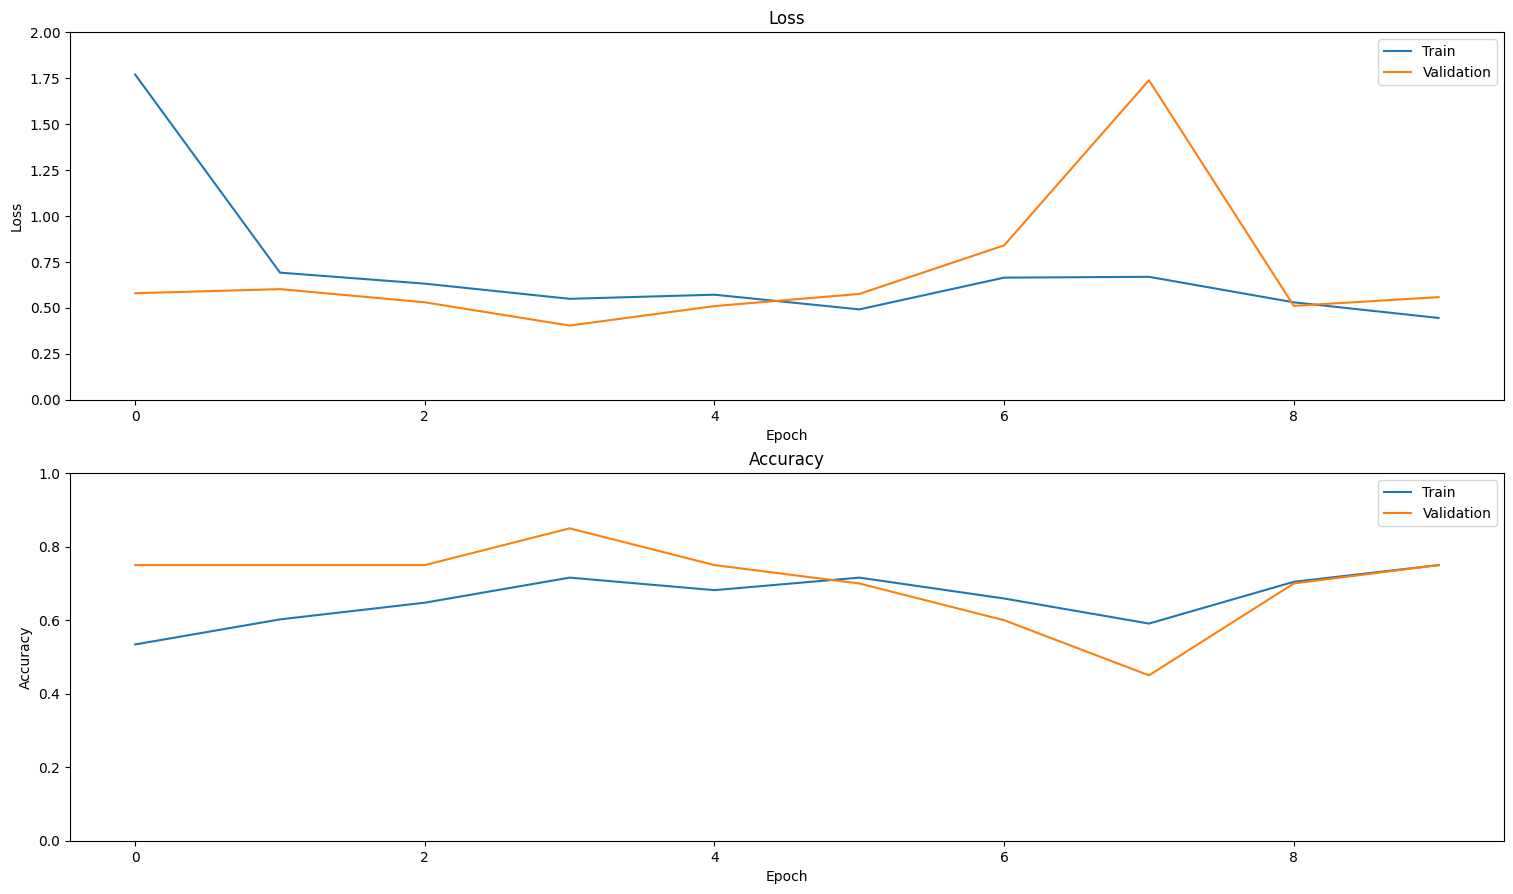

In [ ]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(2)

    fig.set_size_inches(18.5, 10.5)

    # Plot loss
    ax1.set_title('Loss')
    ax1.plot(history.history['loss'], label = 'train')
    ax1.plot(history.history['val_loss'], label = 'test')
    ax1.set_ylabel('Loss')

    # Determine upper bound of y-axis
    max_loss = max(history.history['loss'] + history.history['val_loss'])

    ax1.set_ylim([0, np.ceil(max_loss)])
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'])

    # Plot accuracy
    ax2.set_title('Accuracy')
    ax2.plot(history.history['accuracy'],  label = 'train')
    ax2.plot(history.history['val_accuracy'], label = 'test')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim([0, 1])
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'])

    plt.show()

plot_history(history)

# Model evaluation

In [ ]:
accuracy = model.evaluate(test_dataset, return_dict=True)
print(f"Accuracy: {accuracy}")

3/3 [==============================] - 41s 3s/step - loss: 0.6414 - accuracy: 0.7222
Accuracy: {'loss': 0.641449511051178, 'accuracy': 0.7222222089767456}


# Acknowledgement
This assignment is inspired from https://www.tensorflow.org/tutorials/video/video_classification